In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler

import cmdstanpy
from cmdstanpy import CmdStanModel

In [ ]:
df = pd.read_csv("df_balanced.csv")

In [ ]:
stan_code = r"""
data {
  int<lower=1> N;                       // total observations
  int<lower=1> I;                       // number of donors
  int<lower=1> K;                       // number of target variables (K = 5)
  int<lower=1> P;                       // number of covariates

  array[N] int<lower=1, upper=I> id;     // donor index for each observation
  matrix[N, K] Y;                       // log target variables (preferably centered)
  matrix[N, P] X;                       // covariate matrix
}

parameters {
  // Fixed effects
  matrix[P, K] beta;
  vector<lower=0>[P * K] tau_beta;      // local shrinkage parameters
  real<lower=0> lambda;                 // global shrinkage parameter

  // Random effects
  matrix[I, K] z_b;
  vector<lower=0>[K] tau_b;
  cholesky_factor_corr[K] L_Omega_b;
  vector<lower=0>[K] tau_eps;
  cholesky_factor_corr[K] L_Omega_eps;
}

transformed parameters {
  matrix[K, K] L_Sigma_b = diag_pre_multiply(tau_b, L_Omega_b);
  matrix[I, K] b;
  {
    matrix[K, I] z_b_t = z_b';          // (K x I)
    matrix[K, I] b_t   = L_Sigma_b * z_b_t;    // (K x I)
    b = b_t';                           // (I x K)
  }
  matrix[K, K] L_Sigma = diag_pre_multiply(tau_eps, L_Omega_eps);
}

model {
  // Bayesian LASSO priors for fixed effects
  {
    vector[P * K] beta_vec = to_vector(beta);
    beta_vec ~ normal(rep_vector(0, P * K), sqrt(tau_beta));
    tau_beta ~ exponential(0.5 * square(lambda));
    lambda ~ gamma(1, 1);
  }

  // Prior for random effects
  tau_b ~ normal(0, 0.5) T[0, ];
  L_Omega_b ~ lkj_corr_cholesky(4);
  to_vector(z_b) ~ normal(0, 1);

  // Prior for residual covariance
  tau_eps ~ normal(0, 0.5) T[0, ];
  L_Omega_eps ~ lkj_corr_cholesky(4);

  // Likelihood
  for (n in 1:N) {
    row_vector[K] mu_n = X[n] * beta + b[id[n]];
    Y[n] ~ multi_normal_cholesky(mu_n, L_Sigma);
  }
}

generated quantities {
  vector[N] log_lik;

  // Matrix to store posterior predictions (N x K)
  matrix[N, K] Y_rep;

  // Mean prediction for each observation (N x K)
  matrix[N, K] mu;

  // Full covariance matrices (K x K) from Cholesky factors
  cov_matrix[K] Sigma_b = tcrossprod(L_Sigma_b);
  cov_matrix[K] Sigma_eps = tcrossprod(L_Sigma);

  // Correlation matrices (K x K) from Cholesky factors
  corr_matrix[K] Omega_b = tcrossprod(L_Omega_b);
  corr_matrix[K] Omega_eps = tcrossprod(L_Omega_eps);

  for (n in 1:N) {
    row_vector[K] mu_n_row = X[n] * beta + b[id[n]];
    vector[K] mu_n_vec = mu_n_row';
    mu[n] = mu_n_row;

    // Pointwise Log-likelihood: lpdf expects vector arguments. Y[n] is a row_vector slice.
    log_lik[n] = multi_normal_cholesky_lpdf(Y[n]' | mu_n_vec, L_Sigma);

    // Posterior Prediction: rng returns a vector, but Y_rep[n] is a row_vector slice.
    Y_rep[n] = multi_normal_cholesky_rng(mu_n_vec, L_Sigma)';
  }
}
"""
stan_file = "Model_3.stan"
with open(stan_file, "w") as f:
    f.write(stan_code)

print("Stan model written to:", stan_file)

model = CmdStanModel(stan_file=stan_file)
print("Model compiled.")


13:01:22 - cmdstanpy - INFO - compiling stan file /var/folders/br/6b6r1b7j5hb79g8jd_lks8v00000gn/T/tmpquidahyz/tmpdckwvcid.stan to exe file /Users/noemibongiorni/Desktop/Università/Bayesian Statistics/Progetto AVIS/Model_3


Stan model written to: Model_3.stan


13:01:36 - cmdstanpy - INFO - compiled model executable: /Users/noemibongiorni/Desktop/Università/Bayesian Statistics/Progetto AVIS/Model_3


Model compiled.


In [ ]:
model = CmdStanModel(stan_file=stan_file)
ID_COL = "CAI"
ADD_INTERCEPT = False
target_list = ['PMAX', 'Glucosio', 'Trigliceridi', 'Colesterolo_Hdl', 'BMI']
covariate_cols = df.columns.drop(list(target_list) + [ID_COL])

cols_needed = [ID_COL] + target_list + list(covariate_cols)
df_model = df[cols_needed].dropna().copy()

Y_mat = df_model[target_list].to_numpy(dtype=float)
N, K = Y_mat.shape
X_mat = df_model[covariate_cols].to_numpy(dtype=float)
_, P = X_mat.shape

donor_ids, id_index = np.unique(df_model[ID_COL].to_numpy(), return_inverse=True)
I = len(donor_ids)
id_stan = id_index + 1

stan_data = {
    "N": int(N),
    "I": int(I),
    "K": int(K),
    "P": int(P),
    "Y": Y_mat,
    "X": X_mat,
    "id": id_stan
}

In [ ]:
fit = model.sample(
    data=stan_data,
    chains=4,
    parallel_chains=4,
    iter_warmup=1500,
    iter_sampling=1000,
    adapt_delta=0.9,
    max_treedepth=12,
    show_progress=True
)
print(fit.diagnose())

13:01:37 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/2500 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/2500 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/2500 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/2500 [00:00<?, ?it/s, (Warmup)]

15:11:57 - cmdstanpy - INFO - CmdStan done processing.
15:11:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'Model_3.stan', line 49, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'Model_3.stan', line 49, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'Model_3.stan', line 49, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'Model_3.stan', line 49, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'Model_3.stan', line 49, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'Model_3.stan', line 49, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must 

15:12:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 iterations at max treedepth (0.1%)
	Chain 3 had 5 iterations at max treedepth (0.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Checking sampler transitions treedepth.
6 of 4000 (0.15%) transitions hit the maximum treedepth limit of 12, or 2^12 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete.



In [ ]:
print(fit.diagnose())
summary_df = fit.summary()
summary_df.head(50)

Checking sampler transitions treedepth.
6 of 4000 (0.15%) transitions hit the maximum treedepth limit of 12, or 2^12 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete.



,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,10356.800000,0.596502,18.139000,17.726000,10326.200000,10357.200000,10386.000000,929.079,1869.95,0.117186,1.000850
"beta[1,1]",-0.000938,0.000035,0.002631,0.002568,-0.005246,-0.000996,0.003397,5583.890,2921.77,0.704301,1.000050
"beta[1,2]",0.011550,0.000048,0.003635,0.003604,0.005401,0.011613,0.017496,5821.100,2968.95,0.734220,0.999867
"beta[1,3]",0.030915,0.000190,0.012238,0.012051,0.010527,0.030807,0.051573,4166.670,2828.29,0.525546,1.000430
"beta[1,4]",0.001428,0.000059,0.004091,0.004035,-0.005058,0.001319,0.008381,4880.270,3074.07,0.615553,1.002340
"beta[1,5]",0.003994,0.000024,0.001586,0.001611,0.001353,0.004021,0.006591,4639.680,3129.02,0.585208,1.000220
"beta[2,1]",0.000974,0.000042,0.002954,0.002911,-0.003948,0.000925,0.005826,5143.690,3555.72,0.648778,1.001590
"beta[2,2]",-0.004607,0.000060,0.004086,0.004089,-0.011613,-0.004505,0.001969,4609.200,3039.37,0.581362,1.000590
"beta[2,3]",0.000778,0.000167,0.010650,0.009785,-0.016403,0.000894,0.018541,4099.740,2906.25,0.517104,1.000200
"beta[2,4]",0.005317,0.000071,0.004565,0.004435,-0.002006,0.005205,0.012971,4177.870,3112.32,0.526959,0.999883


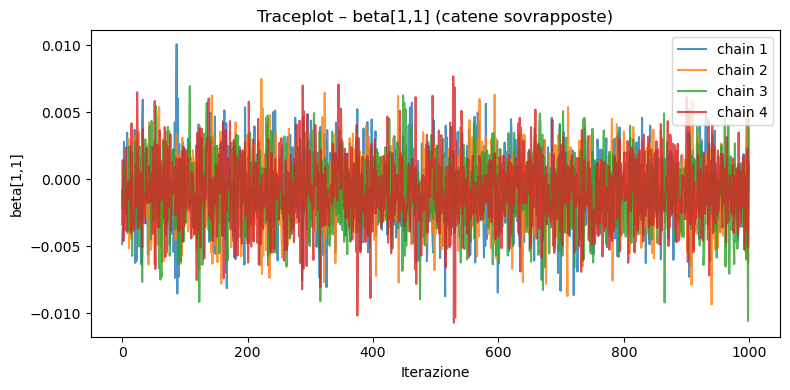

In [ ]:
# Interesting plots

beta = fit.stan_variable("beta")
tot_draws, P, K = beta.shape
chains = fit.chains # number of chains
iters = tot_draws // chains # number of draws per chain

beta_chains = beta.reshape(chains, iters, P, K)

fig, ax = plt.subplots(figsize=(8, 4))

for c in range(chains):
    ax.plot(beta_chains[c, :, 0, 0], label=f"chain {c+1}", alpha=0.8)

ax.set_xlabel("Iterazione")
ax.set_ylabel(f"beta[{0+1},{0+1}]")
ax.set_title(f"Traceplot – beta[{0+1},{0+1}] (catene sovrapposte)")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
with open("Model_3.pkl", "wb") as f:
    pickle.dump(fit, f)